In [1]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [2]:
data = pd.read_sql("select * from sports_data.tourney_games_through_2024_final", conn)

In [3]:
data = data.replace(np.NaN, 0)

In [4]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [5]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'last_10_allowed_free_throw_rate',
       'opponent_last_10_allowed_free_throw_rate',
       'last_10_allowed_free_throw_rate_std',
       'opponent_last_10_allowed_free_throw_rate_std', 'Win_Loss_Flag'],
      dtype='object', length=177)

In [6]:
predictor_cols = data.columns.to_list()

In [7]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [8]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [9]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [10]:
data['Win_Loss_Flag']

0       0
1       1
2       1
3       0
4       1
       ..
2381    0
2382    1
2383    0
2384    1
2385    0
Name: Win_Loss_Flag, Length: 2386, dtype: int64

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [12]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

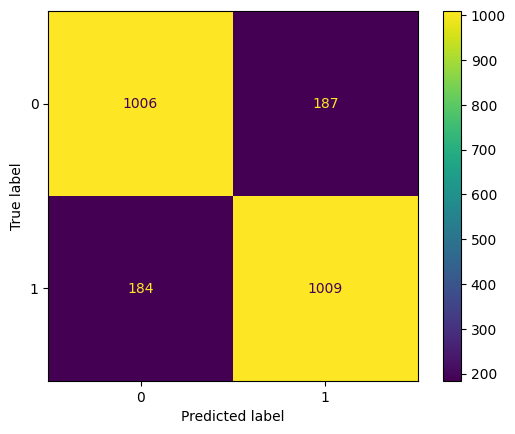

In [13]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [14]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [15]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

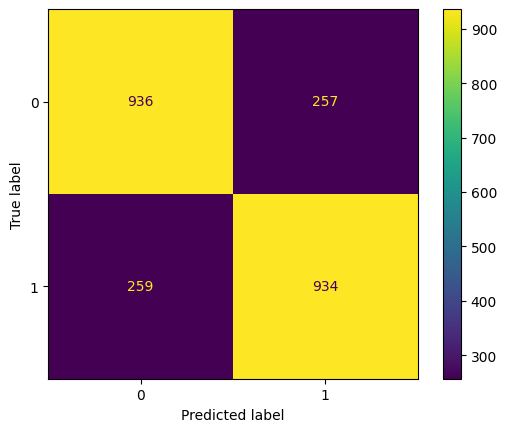

In [16]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [17]:
cms

array([[936, 257],
       [259, 934]], dtype=int64)

In [18]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [19]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [20]:
expected_games_right(cms)

accuracy: 0.7837384744341995


41.091185477242014

In [21]:
expected_score(cms)

89.09272898953914

accuracy: 0.7841575859178541
expected games correct: 41.12685121438517
expected score: 89.22689695884328


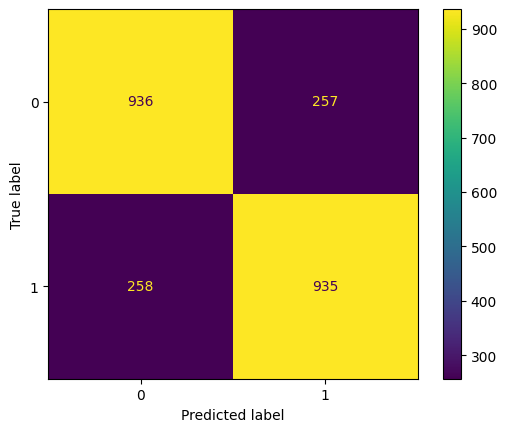

In [22]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

In [23]:
results_df = pd.DataFrame(columns=["n_components", "expected_games_right", "expected_score"])
for i in range(1, 172):
    pca = PCA(n_components=i)
    pca.fit(prediction_data_normalized)
    cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
    results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])

accuracy: 0.5092204526404024
accuracy: 0.6077116512992456
accuracy: 0.6810561609388097
accuracy: 0.7045264040234702
accuracy: 0.702430846605197
accuracy: 0.7095557418273261


C:\Users\amarl\AppData\Local\Temp\ipykernel_6600\1570475966.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])


accuracy: 0.712070410729254
accuracy: 0.7263202011735121
accuracy: 0.7309304274937133
accuracy: 0.7305113160100587
accuracy: 0.731349538977368
accuracy: 0.7330259849119866
accuracy: 0.7380553227158424
accuracy: 0.7372170997485331
accuracy: 0.7376362112321878
accuracy: 0.7367979882648784
accuracy: 0.7384744341994971
accuracy: 0.7372170997485331
accuracy: 0.739731768650461
accuracy: 0.7380553227158424
accuracy: 0.7372170997485331
accuracy: 0.7363788767812238
accuracy: 0.7405699916177704
accuracy: 0.740989103101425
accuracy: 0.7405699916177704
accuracy: 0.742246437552389
accuracy: 0.7380553227158424
accuracy: 0.7376362112321878
accuracy: 0.7338642078792958
accuracy: 0.7321877619446773
accuracy: 0.7284157585917854
accuracy: 0.7330259849119866
accuracy: 0.732606873428332
accuracy: 0.7330259849119866
accuracy: 0.731349538977368
accuracy: 0.7367979882648784
accuracy: 0.7317686504610227
accuracy: 0.7363788767812238
accuracy: 0.7263202011735121
accuracy: 0.7338642078792958
accuracy: 0.732606873

In [24]:
results_df.tail(30)

,n_components,expected_games_right,expected_score
0,142,40.417843,86.580620
0,143,41.448871,90.443313
0,144,41.484766,90.579465
0,145,41.341325,90.036054
0,146,41.305522,89.900699
0,147,40.948750,88.558023
0,148,40.984325,88.691405
0,149,40.984325,88.691405
0,150,41.126851,89.226897
0,151,41.126851,89.226897


In [ ]:
new_data = pd.read_sql("select * from sports_data.tourney_games_2025_potential", conn)
new_data = new_data.replace(np.NaN, 0)

In [153]:
wk = new_data[new_data['team'].str.contains('Conn')]
a = wk[wk['opponent'].str.contains('Hou')].head()[['season_ppg', 'season_ppg_allowed','opponent_season_ppg', 'opponent_season_ppg_allowed']]


In [156]:
(a['season_ppg'] + a['opponent_season_ppg'] + a['season_ppg_allowed'] + a['opponent_season_ppg_allowed']) / 2

32    136.705882
dtype: float64

In [89]:
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
clf = LogisticRegression(random_state=0).fit(pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [91]:
new_prediction_data = new_data[predictor_cols]
new_prediction_data_normalized = (new_prediction_data-prediction_data.mean())/prediction_data.std()
new_data_pca = pca.transform(new_prediction_data_normalized)

In [92]:
new_data['prediction'] = clf.predict(new_data_pca)
new_data['prediction_lose'] = [x[0] for x in clf.predict_proba(new_data_pca)]
new_data['prediction_win'] = [x[1] for x in clf.predict_proba(new_data_pca)]
preds = new_data[['season', 'team', 'opponent', 'prediction', 'prediction_lose', 'prediction_win']]

In [164]:
wk = preds[preds['team'].str.contains('Conn')]
wk[wk['opponent'].str.contains('Houston')]

,season,team,opponent,prediction,prediction_lose,prediction_win
32,2024,Connecticut,Houston,0,0.538391,0.461609
